# Resample a DES cluster lensing chain with seven parameters

In this example, we will read in a DES Year 1 cluster weak lensing chain with six parameters ($\log_{10}M$,$c$,$\tau$,$f_{\rm mis}$,$A_M$,$B_0$,$R_s$) and build an importance sampler for it. We will then resample it and try to recover (essentially) the exact same chain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import scipy.optimize as op
import corner #for making corner plots
import emcee #for doing MCMC
%matplotlib inline

In [2]:
plt.rc("font", size=18, family="serif")
#plt.rc("text", usetex=True)

In [3]:
#Read in the chain and remove burn-in (which I only know is there for this example)
Npoints = 32*1000
input_chain = np.loadtxt("chain_full_y1_SAC_z2_l6.txt")[-Npoints:]
lnpost = np.loadtxt("likes_full_y1_SAC_z2_l6.txt")[-Npoints:]
print("chain shape is  ", input_chain.shape)
print("lnpost shape is ", lnpost.shape)
print np.min(lnpost), np.max(lnpost)

('chain shape is  ', (32000, 7))
('lnpost shape is ', (32000,))
-59.3749589726863 -42.37117705995448


In [4]:
#Pick out only 100 training points
N_training = 300
IS = isamp.ImportanceSampler(input_chain, lnpost, scale = 8)
IS.select_training_points(N_training, method="LH")

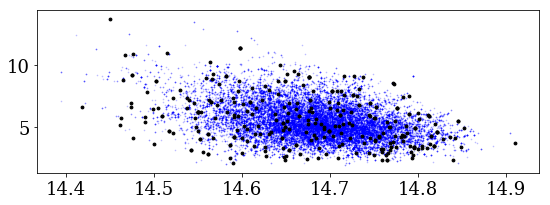

In [5]:
#Visualize the training points selected against the chain
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,3))
plt.subplots_adjust(wspace=0.6)
ax.scatter(input_chain[:,0], input_chain[:,1], c='b', s=0.5, alpha=0.2)

points,_ = IS.get_training_data()
ax.scatter(points[:,0], points[:,1], c='k', s=8)

In [6]:
#Train the GP inside of the sampler
IS.train()

In [7]:
#Run an optimizer to see if we can recover the MLE
def neg_lnpost_predicted(p):
    return -IS.predict(p)
guess = input_chain[np.argmax(lnpost)]
result = op.minimize(neg_lnpost_predicted, guess, method="Nelder-Mead")
print(result)

 final_simplex: (array([[14.70386355,  4.83929122,  0.17511584,  0.24276739,  1.01270148,
         0.04177692,  1.6078122 ],
       [14.70385966,  4.83934744,  0.1751153 ,  0.24276483,  1.01270199,
         0.04177861,  1.60774735],
       [14.70386555,  4.83936695,  0.175115  ,  0.24276603,  1.0127025 ,
         0.0417782 ,  1.6077648 ],
       [14.70386464,  4.83931596,  0.17511367,  0.24276735,  1.01270234,
         0.04177726,  1.60782489],
       [14.70386142,  4.83938396,  0.17511538,  0.24276937,  1.01270139,
         0.04177851,  1.60775944],
       [14.70386471,  4.83931748,  0.17511465,  0.24275985,  1.01270177,
         0.04177849,  1.60776241],
       [14.70386044,  4.83937364,  0.17511777,  0.24276267,  1.01270279,
         0.04177555,  1.60787015],
       [14.7038662 ,  4.83929285,  0.17511228,  0.24276307,  1.01269949,
         0.04177664,  1.60782079]]), array([42.32731757, 42.32731757, 42.32731757, 42.32731757, 42.32731757,
       42.32731758, 42.32731758, 42.32731758]

In [19]:
nwalkers = 16
nd = len(input_chain[0])
pos = np.array([result.x + result.x*1e-3*np.random.randn(nd) for i in range(nwalkers)])
sampler = emcee.EnsembleSampler(nwalkers, nd, IS.predict)
_ = sampler.run_mcmc(pos, 7000)

In [20]:
test_chain = sampler.flatchain[32*1000:]
print np.mean(input_chain, 0), np.std(input_chain, 0)
print np.mean(test_chain, 0), np.std(test_chain, 0)

[14.68248502  5.43777183  0.17578599  0.25191814  1.01622081  0.04650065
  2.14894103] [0.06511475 1.42564003 0.04123589 0.08007405 0.02610007 0.0309178
 1.3658311 ]
[14.68885234  5.34607719  0.17794954  0.25590326  1.01328532  0.05085586
  2.20491288] [0.07079305 1.48039342 0.03911244 0.07921264 0.02609236 0.03887579
 1.44240367]


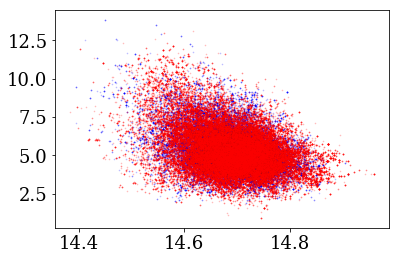

In [21]:
fig, ax = plt.subplots()
ax.scatter(input_chain[:,0], input_chain[:,1], c='b', s=0.5, alpha=0.2)
ax.scatter(test_chain[:,0], test_chain[:,1], c='r', s=0.5, alpha=0.2)

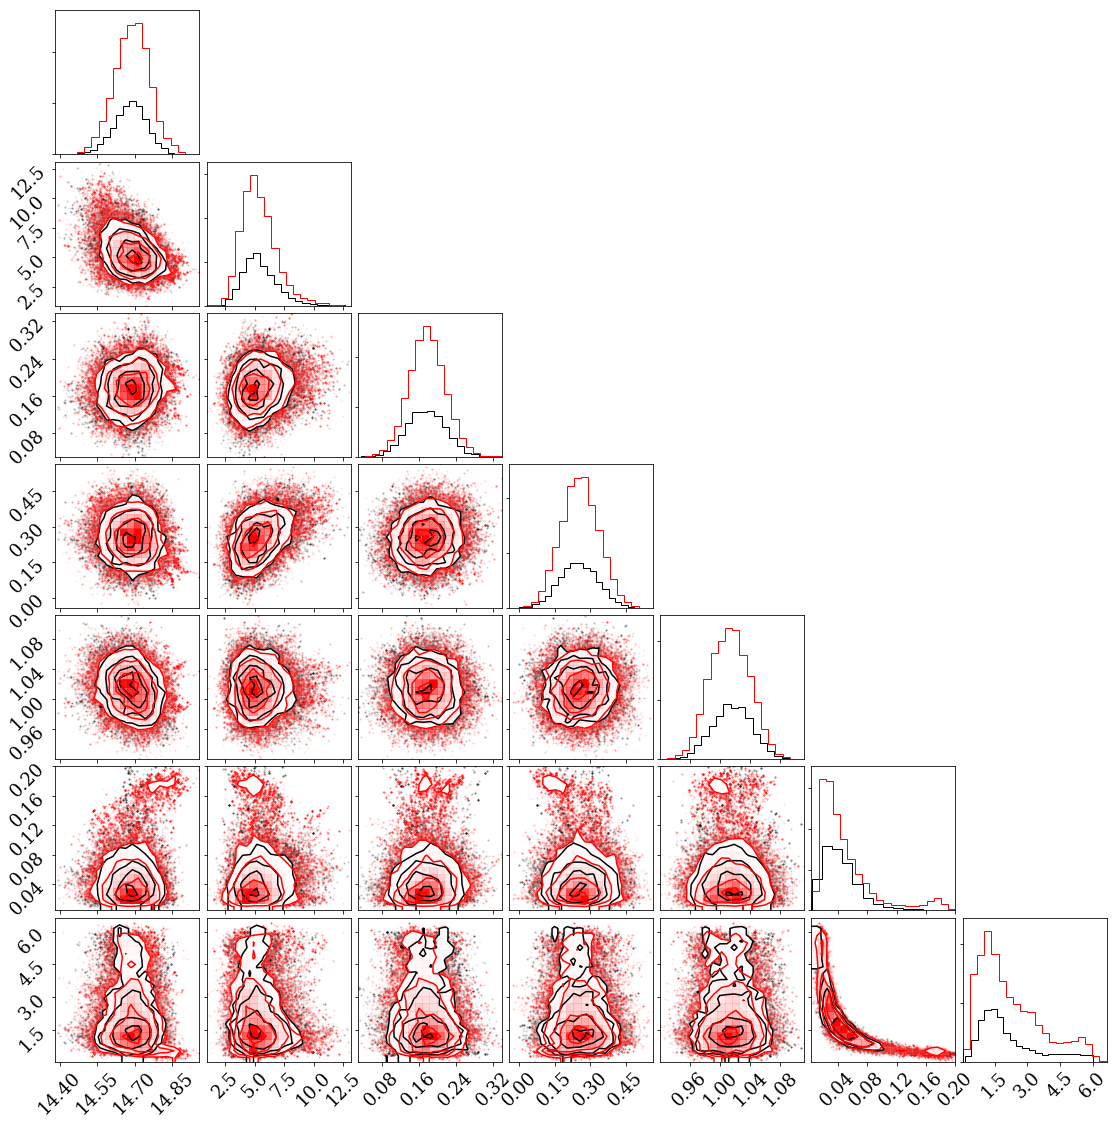

In [22]:
fig = corner.corner(input_chain)
fig = corner.corner(test_chain, fig=fig, color='r')
fig.savefig("sevenD_test.png", dpi=300, bbox_inches="tight")